# DX 704 Week 2 Project

This week's project will analyze fresh strawberry price data for a hypothetical "buy low, freeze, and sell high" business.
Strawberries show strong seasonality in their prices compared to other fruits.

![](https://ers.usda.gov/sites/default/files/_laserfiche/Charts/61401/oct14_finding_plattner_fig01.png)

Image source: https://www.ers.usda.gov/amber-waves/2014/october/seasonal-fresh-fruit-price-patterns-differ-across-commodities-the-case-of-strawberries-and-apples

You are considering a business where you buy strawberries when the prices are very low, carefully freeze them, even more carefully defrost them, and then sell them when the prices are high.
You will forecast strawberry price time series and then use them to tactically pick times to buy, freeze, and sell the strawberries.

The full project description, a template notebook, and raw data are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-02


### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Backtest Strawberry Prices

Read the provided "strawberry-prices.tsv" with data from 2020 through 2024.
This data is based on data from the U.S. Bureau of Statistics, but transformed so the ground truth is not online.
https://fred.stlouisfed.org/series/APU0000711415

Use the data for 2020 through 2023 to predict monthly prices in 2024.
Spend some time to make sure you are happy with your methodology and prediction accuracy, since you will reuse the methodology to forecast 2025 next.
Save the 2024 backtest predictions as "strawberry-backtest.tsv" with columns month and price.


In [30]:
# YOUR CHANGES HERE

import pandas as pd

# Read in TSV file
df = pd.read_csv("strawberry-prices.tsv", sep="\t", header=0)

In [31]:
df.head()

,month,price
0,2020-01-01,4.0490
1,2020-02-01,3.6250
2,2020-03-01,3.3770
3,2020-04-01,3.2328
4,2020-05-01,3.1260


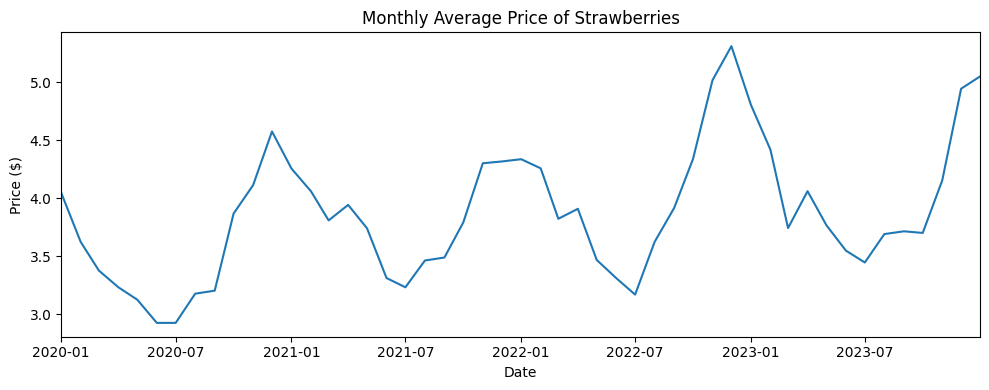

In [32]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

df = df.reset_index()

df["month"] = pd.to_datetime(df["month"])
df = df.sort_values("month").set_index("month")

# Plot price over time
plt.figure(figsize=(10,4))
plt.plot(df.index, df["price"])
plt.title("Monthly Average Price of Strawberries")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.xlim(df.index.min(), pd.to_datetime("2023-12-31"))
plt.tight_layout()
plt.show()

In [33]:
import numpy as np
from pathlib import Path

df.columns = df.columns.astype(str).str.strip().str.lower()
df = df.reset_index()

# Parse month to datetime and sort
df['month'] = pd.to_datetime(df['month'])
df = df.sort_values('month').reset_index(drop=True)

# Split train (2020–2023) and create a complete monthly index
train = df[(df['month'] >= '2020-01-01') & (df['month'] < '2024-01-01')].copy()
all_months_train = pd.date_range('2020-01-01', '2023-12-01', freq='MS')
train = train.set_index('month').reindex(all_months_train).rename_axis('month')
train['price'] = train['price'].interpolate(method='time')

# Forecast 2024 (Holt-Winters)
forecast_index = pd.date_range('2024-01-01', '2024-12-01', freq='MS')
y = train['price'].astype(float)

try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    model = ExponentialSmoothing(
    y, trend='add', damped_trend=True, seasonal='add', seasonal_periods=12,
        initialization_method='estimated'
    ).fit(optimized=True, use_brute=True)
    preds = pd.Series(model.forecast(len(forecast_index)).values, index=forecast_index)
except Exception:
    # Seasonal-naive fallback: average price for each calendar month across 2020–2023
    monthly_means = y.groupby(y.index.month).mean()
    preds = pd.Series([monthly_means[m] for m in forecast_index.month], index=forecast_index)

preds = preds.clip(lower=0)

# Save as TSV
out = pd.DataFrame({'month': preds.index.strftime('%Y-%m-%d'), 'price': preds.values})
out.to_csv("strawberry-backtest.tsv", sep="\t", index=False)

Submit "strawberry-backtest.tsv" in Gradescope.

## Part 2: Backtest Errors

What are the mean and standard deviation of the residuals between your backtest predictions and the ground truth? (If your mean is not close to zero, then you may be missing a long term trend.)

Write the mean and standard deviation to a file "backtest-accuracy.tsv" with two columns, mean and std.

In [34]:
# YOUR CHANGES HERE

actual_2024 = df[(df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")][["month", "price"]].copy()
pred_df = pd.DataFrame({"month": forecast_index, "pred": preds.values})

merged = actual_2024.merge(pred_df, on="month", how="inner").sort_values("month")
merged["residual"] = merged["price"] - merged["pred"]

mean_resid = merged["residual"].mean()
std_resid = merged["residual"].std(ddof=1)

# Save accuracy file
pd.DataFrame({"mean": [mean_resid], "std": [std_resid]}).to_csv("backtest-accuracy.tsv", sep="\t", index=False)

In [35]:
merged

,month,price,pred,residual
0,2024-01-01,5.055,4.362750,0.692250
1,2024-02-01,4.264,4.091250,0.172750
2,2024-03-01,3.742,3.688750,0.053250
3,2024-04-01,3.576,3.787200,-0.211200
4,2024-05-01,3.237,3.526250,-0.289250
5,2024-06-01,2.977,3.275000,-0.298000
6,2024-07-01,3.116,3.194000,-0.078000
7,2024-08-01,3.347,3.489750,-0.142750
8,2024-09-01,3.742,3.581750,0.160250
9,2024-10-01,3.718,3.926000,-0.208000


Submit "backtest-accuracy.tsv" in Gradescope.

## Part 3: Forecast Strawberry Prices

Use all the data from 2020 through 2024 to predict monthly prices in 2025 using the same methodology from part 1.
Make a monthly forecast for each month of 2025 and save it as "strawberry-forecast.tsv" with columns for month and price.

In [15]:
# YOUR CHANGES HERE

#df.columns = df.columns.astype(str).str.strip().str.lower()
#df = df.reset_index()

# Parse month to datetime and sort
df['month'] = pd.to_datetime(df['month'])
df = df.sort_values('month').reset_index(drop=True)

# Train on all 2020–2024 and create a complete monthly index
train = df[(df['month'] >= '2020-01-01') & (df['month'] < '2025-01-01')].copy()
all_months_train = pd.date_range('2020-01-01', '2024-12-01', freq='MS')
train = train.set_index('month').reindex(all_months_train).rename_axis('month')
train['price'] = train['price'].interpolate(method='time')

# Forecast 2024 (Holt-Winters)
forecast_index = pd.date_range('2025-01-01', '2025-12-01', freq='MS')
y = train['price'].astype(float)

try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    model = ExponentialSmoothing(
    y, trend='add', damped_trend=True, seasonal='add', seasonal_periods=12,
        initialization_method='estimated'
    ).fit(optimized=True, use_brute=True)
    preds = pd.Series(model.forecast(len(forecast_index)).values, index=forecast_index)
except Exception:
    # Seasonal-naive fallback: average price for each calendar month across 2020–2023
    monthly_means = y.groupby(y.index.month).mean()
    preds = pd.Series([monthly_means[m] for m in forecast_index.month], index=forecast_index)

preds = preds.clip(lower=0)

# Save as TSV
out = pd.DataFrame({'month': preds.index.strftime('%Y-%m-%d'), 'price': preds.values})
out.to_csv("strawberry-forecast.tsv", sep="\t", index=False)

Submit "strawberry-forecast.tsv" in Gradescope.

## Part 4: Buy Low, Freeze and Sell High

Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.
Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.
So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.
To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [17]:
# YOUR CHANGES HERE

# Load forecasted 2025 prices
df2 = pd.read_csv('strawberry-forecast.tsv', sep="\t")

# Ensure datetime and sort
df2["month"] = pd.to_datetime(df2["month"])
df2 = df2[df2["month"].dt.year == 2025].sort_values("month").reset_index(drop=True)

# Parameters
freeze_cost = 0.20  # per pint
storage_cost_month = 0.10  # per pint per month
discount = 0.9  # 10% discount on resale
budget = 1_000_000

results = []

# Evaluate all buy/sell month pairs
for i, buy_row in df2.iterrows():
    for j, sell_row in df2.iterrows():
        if j <= i:
            continue  # must sell after buy

        months_stored = (sell_row["month"].to_period("M") - buy_row["month"].to_period("M")).n
        buy_price = buy_row["price"]
        sell_price = sell_row["price"]

        # Effective sell price after discount
        effective_sell = sell_price * discount

        # Cost per pint: purchase + freeze + storage
        total_cost_per_pint = buy_price + freeze_cost + storage_cost_month * months_stored

        # Revenue per pint
        revenue_per_pint = effective_sell

        profit_per_pint = revenue_per_pint - total_cost_per_pint

        if profit_per_pint > 0:
            # How many pints can we buy within budget (considering cost of purchase + freeze + storage)
            pints = budget // total_cost_per_pint
            total_profit = pints * profit_per_pint

            results.append({
                "buy_month": buy_row["month"].strftime("%Y-%m"),
                "sell_month": sell_row["month"].strftime("%Y-%m"),
                "pints_purchased": int(pints),
                "expected_profit": round(total_profit, 2)
            })

# Convert to DataFrame
timings_df = pd.DataFrame(results)

# Save to file
timings_df.to_csv('timings.tsv', sep="\t", index=False)

timings_df

,buy_month,sell_month,pints_purchased,expected_profit
0,2025-06,2025-11,255401,11942.55
1,2025-06,2025-12,249041,76364.44
2,2025-07,2025-11,264662,48634.29
3,2025-07,2025-12,257838,114385.70
4,2025-08,2025-11,252448,242.35
5,2025-08,2025-12,246232,64225.68
6,2025-09,2025-12,243084,50618.35
7,2025-10,2025-12,233404,8783.93


Submit "timings.tsv" in Gradescope.

## Part 5: Strategy Check

What is the best profit scenario according to your previous timing analysis?
How much does that profit change if the sell price is off by one standard deviation from your backtest analysis?
(Variation in the sell price is more dangerous because you can see the buy price before fully committing.)

Write the results to a file "check.tsv" with columns best_profit and one_std_profit.

In [26]:
# YOUR CHANGES HERE

best_profit = timings_df.loc[3, "expected_profit"]

acc = pd.read_csv("backtest-accuracy.tsv", sep="\t")

one_std = float(acc["std"].iloc[0])

# Recompute one_std_profit
one_std_profit = best_profit - (one_std * pints)

# Save results
pd.DataFrame({
    "best_profit": [best_profit],
    "one_std_profit": [one_std_profit]
}).to_csv('check.tsv', sep="\t", index=False)

Submit "check.tsv" in Gradescope.

## Part 6: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgments are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 7: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.